In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Activation, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, dot, Dropout
from sklearn.metrics import mean_squared_error as mse

In [ ]:
df=pd.read_csv('/content/train.csv')
df

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43770,31-12-2019 19:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
43771,31-12-2019 20:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
43772,31-12-2019 21:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
43773,31-12-2019 22:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0


In [ ]:
df['datetime']=pd.to_datetime(df['datetime'])
df=df.set_index('datetime')

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(df)
df_for_training_scaled

array([[-1.10462746, -0.91747214,  0.12897489, ..., -0.22523732,
        -0.25820204, -1.68530387],
       [-1.40522847, -0.89689509,  0.17742332, ..., -0.22523732,
        -0.25820204, -1.68530387],
       [-1.46675841, -0.87387983,  0.24959389, ..., -0.22523732,
        -0.25820204, -1.68530387],
       ...,
       [ 0.04949601, -0.62137691, -0.24689001, ...,  6.55504517,
         3.87293616, -1.68530387],
       [-0.27721829, -0.73490163, -0.25623449, ...,  6.55504517,
         3.87293616, -1.68530387],
       [-0.51484757, -0.85021807, -0.18887726, ...,  6.55504517,
         3.87293616, -1.68530387]])

In [ ]:
def df_to_X_y2(df, window_size=6):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = [r for r in df[i:i+window_size]]
    X.append(row)
    label = df[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X,y=df_to_X_y2(df_for_training_scaled)
split=int(len(df)*0.9)
X_train=X[:split]
y_train=y[:split]
X_test=X[split:]
y_test=y[split:]
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((39397, 6, 16), (39397,), (4372, 6, 16), (4372,))

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Epoch 1/100
1109/1109 [==============================] - 28s 19ms/step - loss: 0.0924 - val_loss: 0.0699
Epoch 2/100
1109/1109 [==============================] - 22s 19ms/step - loss: 0.0337 - val_loss: 0.0606
Epoch 3/100
1109/1109 [==============================] - 21s 19ms/step - loss: 0.0270 - val_loss: 0.0424
Epoch 4/100
1109/1109 [==============================] - 20s 18ms/step - loss: 0.0233 - val_loss: 0.0317
Epoch 5/100
1109/1109 [==============================] - 21s 19ms/step - loss: 0.0214 - val_loss: 0.0442
Epoch 6/100
1109/1109 [==============================] - 20s 18ms/step - loss: 0.0199 - val_loss: 0.0361
Epoch 7/100
1109/1109 [==============================] - 21s 19ms/step - loss: 0.0187 - val_loss: 0.0396
Epoch 8/100
1109/1109 [==============================] - 20s 18ms/step - loss: 0.0175 - val_loss: 0.0400
Epoch 9/100
1109/1109 [==============================] - 21s 19ms/step - loss: 0.0169 - val_loss: 0.0342
Epoch 10/100
1109/1109 [==============================]

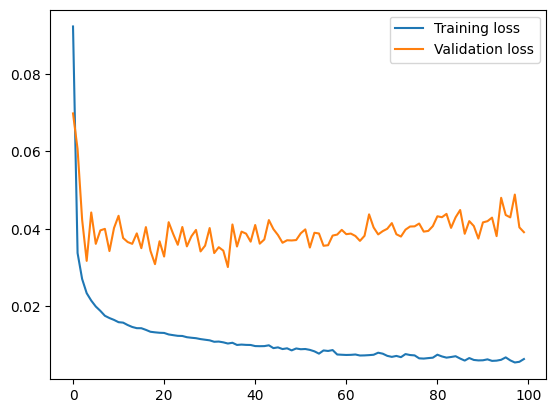

In [ ]:
# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions),np.sqrt(mse(y, predictions))

137/137 [==============================] - 1s 4ms/step


(      Predictions   Actuals
 0        0.564978  0.747513
 1        0.433898  0.592319
 2        0.239137  0.250698
 3       -0.108627 -0.055278
 4       -0.371868 -0.410539
 ...           ...       ...
 4367     0.519561  0.607224
 4368     0.317429  0.345517
 4369     0.058797  0.049496
 4370    -0.197493 -0.277218
 4371    -0.480904 -0.514848
 
 [4372 rows x 2 columns],
 0.023798965767468278,
 0.1542691342021089)

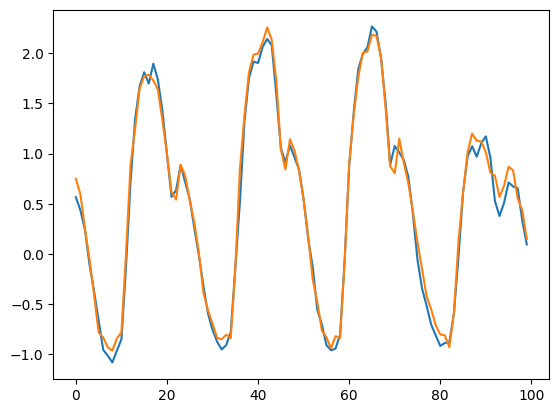

In [ ]:
plot_predictions(model, X_test, y_test)

In [ ]:
predictions = model.predict(X_test)
y_test=y_test.reshape(-1,1)
y_test.shape

137/137 [==============================] - 1s 5ms/step


(4372, 1)

In [ ]:
d=df_for_training_scaled[-4372:,:]
Y_predicted = np.concatenate((predictions,d[-4372:,1:]), axis =1)
Y_tested = np.concatenate((y_test, d[-4372:,1:]), axis = 1)
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (4372, 1)
Y_predicted (4372, 1)


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
mse = mean_squared_error(Y_tested, Y_predicted)
mae=mean_absolute_error(Y_tested,Y_predicted)
mape=mean_absolute_percentage_error(Y_tested,Y_predicted)
rmse = np.sqrt(mse)
print('mean squared error: ',mse)
print('root mean squared error: ',rmse)
print('mean absolute error: ',mae)
print('mean absolute pourcentage error : ',mape)

mse:  891.1850530030517
rmse:  29.852722706698827
mae:  21.284347956259573
mape:  0.01720661445328411


In [ ]:
df2=pd.DataFrame(data={'Actuals': Y_tested.flatten(),'Predictions': Y_predicted.flatten()})
df2=df2.set_index(df[-4372:].index)
df2

,Actuals,Predictions
datetime,,
2019-02-07 20:00:00,1328.7539,1293.431418
2019-02-07 21:00:00,1298.7222,1268.066166
2019-02-07 22:00:00,1232.6149,1230.377794
2019-02-07 23:00:00,1173.4053,1163.081653
2019-03-07 00:00:00,1104.6586,1112.141861
...,...,...
2019-12-31 19:00:00,1301.6065,1284.642730
2019-12-31 20:00:00,1250.9634,1245.528041
2019-12-31 21:00:00,1193.6802,1195.480021


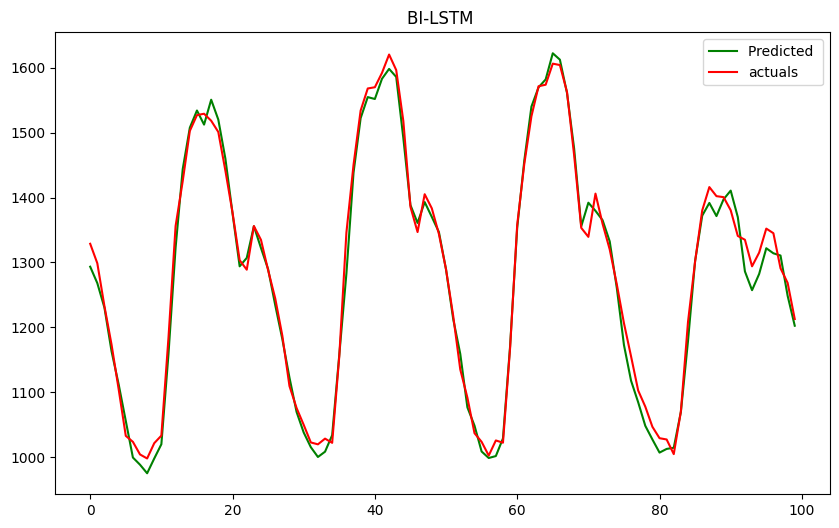

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:100,:], color= 'green',label = 'Predicted ')
plt.plot(Y_tested [:100,:], color = 'red',label = 'actuals')
plt.title('BI-LSTM ')
plt.legend()
plt.show()

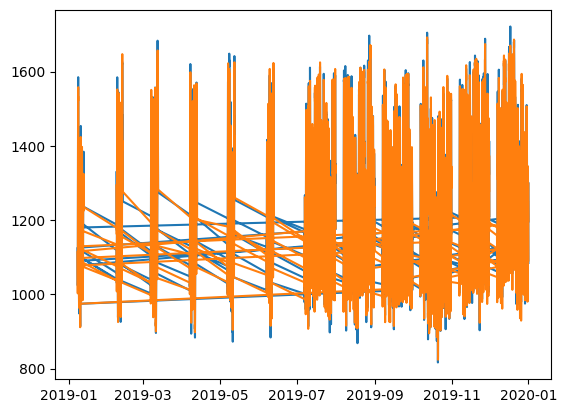

In [ ]:
plt.plot(df2)